In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys

In [2]:
# Path para importacion de funciones
dir_current    = os.path.abspath('')
dir_parent = os.path.dirname(dir_current)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading Dataset

In [3]:
x_test,  y_test  = tfds.as_numpy(tfds.load('deep_weeds', split='train[85%:]', batch_size=-1, as_supervised=True))

## Creating Dataset Objects

In [4]:
Nclasses = 9
def to_categorical(x_, y_):
    return x_, tf.one_hot(y_, depth = Nclasses)
def normalize(x_, y_):
    return tf.cast(x_, tf.float32) / 255., y_

In [5]:
from functions import VGG_resize

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.map(normalize)
test_dataset = test_dataset.map(VGG_resize)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

In [6]:
from models import VGG16_body

Activations_Int_bits  = 5
Activations_Frac_bits = 6

input_layer   = tf.keras.Input((224,224,3))
output_layer  = VGG16_body(input_layer, Quantization = False, N_labels = Nclasses)

#For this example we using 8 bits of precision.
Qinput_layer  = tf.keras.Input((224,224,3))
Qoutput_layer = VGG16_body(Qinput_layer, Quantization = True, 
                           word_size = 1 + Activations_Int_bits + Activations_Frac_bits,
                           frac_size = Activations_Frac_bits, N_labels = Nclasses)

VGG16  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
QVGG16 = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [10]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'WeedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

VGG16.load_weights(Wgt_dir)
QVGG16.load_weights(Wgt_dir)

## Quantize weights

In [11]:
from models import Weight_Quantization
Weight_Int_bits  = 3
Weight_Frac_bits = 8

Weight_Quantization(model = QVGG16, Frac_Bits = Weight_Frac_bits, Int_Bits = Weight_Int_bits)

## Checking the model predictions

In [11]:
import time
import matplotlib.pyplot as plt

# Iterator over test Dataset
iterator  = iter(test_dataset)

Target: 8
Prediction: 8
QPrediction: 8


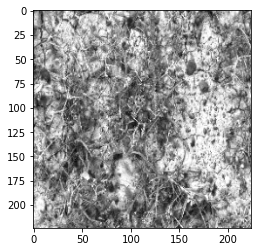

In [13]:
# Getting new image from iterator
image     = next(iterator)
image_plt = image[0][0,...,0]

# Plotting Test image
plt.imshow(image_plt, cmap='gray')

# Target
tf.print("Target:",np.argmax(image[1]))
# Predicted Output
print("Prediction:",np.argmax(VGG16.predict(image[0])))
# Quantized Predicted Output
print("QPrediction:",np.argmax(QVGG16.predict(image[0])))

## Comparation of Output

In [14]:
VGG16.predict(image[0])

array([[3.7478830e-04, 3.0615769e-04, 2.1261885e-04, 1.3204045e-03,
        3.0861160e-04, 4.9349750e-05, 6.5105001e-04, 8.1385131e-04,
        9.9596316e-01]], dtype=float32)

In [15]:
QVGG16.predict(image[0])

array([[0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Check the general Accuracy

In [12]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
VGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QVGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
VGG16.evaluate(test_dataset)

2626/2626 [==============================] - 40s 15ms/step - loss: 0.9991 - accuracy: 0.6314


[0.9991152099213032, 0.63137853]

In [18]:
QVGG16.evaluate(test_dataset)

2626/2626 [==============================] - 51s 19ms/step - loss: 1.1994 - accuracy: 0.6291


[1.199420287556129, 0.6290937]

## Checking The Output of Each Layer

In [ ]:
from functions import get_all_outputs
# List for layer names.

Layer_Names = []
for layer in VGG16.layers:
    Layer_Names.append(layer.name)

QLayer_Names = []
for layer in QVGG16.layers:
    QLayer_Names.append(layer.name)
    
# Dictionary with layer name -> outputs
Layers_Outputs  = dict(zip(Layer_Names, get_all_outputs(VGG16,image[0])))
QLayers_Outputs = dict(zip(QLayer_Names, get_all_outputs(QVGG16,image[0])))

## Comparing Outputs for The convolution #3

In [ ]:
Layers_Outputs

In [ ]:
QLayers_Outputs

## Testing Max and Min Values of Each Layer for the original model

In [24]:
N_layers  = len(QVGG16.layers)
iterator  = iter(test_dataset)
image     = next(iterator,'Stop')
Max_values = [0]*N_layers
Min_values = [0]*N_layers
while image != 'Stop':
    Model_outputs = get_all_outputs(VGG16,image[0])
    Max_iteration_values = np.array([np.max(itm) for itm in Model_outputs])
    Min_iteration_values = np.array([np.min(itm) for itm in Model_outputs])
    Max_values = np.maximum(Max_values, Max_iteration_values)
    Min_values = np.minimum(Min_values, Min_iteration_values)
    image = next(iterator,'Stop')

In [33]:
print('valores maximos de cada capa:')
Max_values

valores maximos de cada capa:


array([1.        , 1.        , 0.78338563, 0.78338563, 0.78338563,
       0.78338563, 0.47743437, 0.47743437, 0.47743437, 0.47743437,
       0.47743437, 0.24904501, 0.24904501, 0.24904501, 0.24904501,
       0.27275437, 0.27275437, 0.27275437, 0.27275437, 0.27275437,
       0.24456985, 0.24456985, 0.24456985, 0.24456985, 0.59097719,
       0.59097719, 0.59097719, 0.59097719, 1.20200562, 1.20200562,
       1.20200562, 1.20200562, 1.20200562, 1.93179297, 1.93179297,
       1.93179297, 1.93179297, 2.26175141, 2.26175141, 2.26175141,
       2.26175141, 2.41889429, 2.41889429, 2.41889429, 2.41889429,
       2.41889429, 0.97872788, 0.97872788, 0.97872788, 0.97872788,
       0.73662627, 0.73662627, 0.73662627, 0.73662627, 1.19270968,
       1.19270968, 1.19270968, 1.19270968, 1.19270968, 1.19270968,
       1.61061215, 1.61061215, 1.61061215, 1.61061215, 1.92207038,
       1.92207038, 1.92207038, 1.92207038, 9.70611954, 9.70611954,
       0.99889648, 0.99889648])

In [34]:
print('valores minimos de cada capa:')
Min_values

valores minimos de cada capa:


array([  0.        ,   0.        ,  -0.93404377,  -0.93404377,
         0.        ,   0.        ,  -0.43272799,  -0.43272799,
         0.        ,   0.        ,   0.        ,  -0.30962095,
        -0.30962095,   0.        ,   0.        ,  -0.34334949,
        -0.34334949,   0.        ,   0.        ,   0.        ,
        -0.37578222,  -0.37578222,   0.        ,   0.        ,
        -0.53157425,  -0.53157425,   0.        ,   0.        ,
        -1.13386619,  -1.13386619,   0.        ,   0.        ,
         0.        ,  -2.24934244,  -2.24934244,   0.        ,
         0.        ,  -3.30575824,  -3.30575824,   0.        ,
         0.        ,  -2.65877509,  -2.65877509,   0.        ,
         0.        ,   0.        ,  -3.31220746,  -3.31220746,
         0.        ,   0.        ,  -1.2586894 ,  -1.2586894 ,
         0.        ,   0.        ,  -1.37292671,  -1.37292671,
         0.        ,   0.        ,   0.        ,   0.        ,
        -3.07700133,  -3.07700133,   0.        ,   0.  

## Checking max and min values of weights

In [28]:
for itm in VGG16.get_weights():
    print(np.max(itm))

0.104181185
0.016873378
0.1089397
0.01558271
0.09763098
0.016158935
0.087240025
0.014526674
0.08111495
0.00824571
0.07029645
0.0053515034
0.070084706
0.0032959275
0.062997594
0.0037358636
0.0607679
0.008119496
0.05753423
0.0057301885
0.053162318
0.0066011925
0.06433434
0.0090884995
0.06629688
0.016662626
0.06053435
0.016358716
0.064490445
0.018905964
0.054028854
0.011967614


In [29]:
for itm in VGG16.get_weights():
    print(np.min(itm))

-0.10610664
-0.011455884
-0.109215885
-0.008328031
-0.10030339
-0.008590696
-0.09325274
-0.009320481
-0.08804138
-0.009421519
-0.073861524
-0.008828881
-0.06600946
-0.0077685113
-0.079259545
-0.010191236
-0.071513474
-0.0106452955
-0.06581518
-0.013686386
-0.07360977
-0.018227858
-0.060023088
-0.023218513
-0.06585209
-0.018700011
-0.074821256
-0.01658692
-0.066666976
-0.011554399
-0.15878317
-0.011684112
